This notebook is mainly not mine but, I will add some parts to make it like a tutorial for myself, and then |I will change it to test my idea.

Based on: https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

Source: https://github.com/praxidike97/GraphNeuralNet/blob/72c330bb6e64dd7dd6784b6e69a821149dc5d028/main.py#L114

In [186]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [188]:
import random
random.seed(10)

# what we need

## Graph Class

In [189]:
from itertools import filterfalse
class Graph:
    def __init__(self,nV):
        self.nV = nV
        self.V = list(range(nV))
        self.lenE = 0
        self.VnV = [[] for i in range(nV)]
        self.emV = []
        self.cc = []

    def add_edge(self,v1,v2,directed=False):
        self.VnV[v1].append(v2)
        if not directed:
            self.VnV[v2].append(v1)
        
        self.lenE += 1

    def add_self_loop(self):
        for i in range(self.nV):
            self.VnV[i].append(i)
        self.lenE += self.nV

    def create_embedding(self):
        self.emV = []
        for i in range(self.nV):
            temp = [0 for i in range(self.nV)]
            for j in self.VnV[i]:
                temp[j] = 1
            self.emV.append(temp[:])
        return self.emV
    
    def create_embedding_based_on_input(self,edges):
        self.emboi = np.zeros((self.nV,self.nV))
        for i in range(len(edges[0])):
            self.emboi[edges[0][i]][edges[1][i]] = 1
        return self.emboi

    def create_random_edges(self,index_list,num,avoid_self_loop=False,directed=False):
        for i in range(num):
            e1 = random.choice(index_list)
            e2 = random.choice(index_list)
            if avoid_self_loop:
                while(e2 == e1):
                     e2 = random.choice(index_list)
            self.add_edge(e1,e2,directed=directed)
    
    def clear_redundant_edges(self):
        self.lenE = 0
        for i in range(len(self.VnV)):
            self.VnV[i] = list(set(self.VnV[i]))
            self.lenE += len(self.VnV[i])
            self.lenE += i in self.VnV[i]
        self.lenE/=2

    def ask_nE(self,ifprint=False):
        if ifprint:
            print(int(self.lenE))
        return int(self.lenE)
    
    def edge_index(self):
        E1 = []
        E2 = []
        for i in range(self.nV):
            for j in self.VnV[i]:
                E1.append(i)
                E2.append(j)
        return [E1,E2]

    @staticmethod
    def is_commonelems(x,y):
        for value in x:
            if value in y:
                return True
        return False

    def update_cc(self,index_list):
        self.cc.append(index_list)

    def create_connected_component(self,index_list,nE):
        self.update_cc(index_list)

        n = max(nE-len(index_list)+1,0)
        fill = [index_list[0],index_list[1]]
        self.add_edge(index_list[0],index_list[1])
        for i in range(3,len(index_list)):
            fill.append(index_list[i])
            self.add_edge(index_list[i],random.choice(fill))
        for i in range(n):
            self.add_edge(random.choice(fill),random.choice(fill))

g = Graph(10)
g.add_edge(1,2)
g.add_edge(0,1)
g.add_edge(3,4)
g.create_random_edges(list(range(5,10)),7)
g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
print(g.edge_index())
g.create_embedding()


18
[[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9], [0, 1, 0, 1, 2, 1, 2, 3, 4, 3, 4, 9, 5, 6, 8, 5, 6, 8, 7, 8, 9, 6, 7, 8, 9, 5]]


[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 1]]

# create dataset

In [190]:
class Data:
    def __init__(self,g):
        self.x = np.array(g.create_embedding())
        self.num_node_features = g.nV
        self.edge_index = np.array(g.edge_index())

    def create_mask(self,train_ratio=0.7):
        self.test_mask = []
        self.train_mask = []
        for i in range(len(self.edge_index[0])):
            if random.random()>train_ratio:
                self.test_mask.append(True)
                self.train_mask.append(False)

            else:
                self.train_mask.append(True)
                self.test_mask.append(False)


    def safe_create_mask(self,train_ratio=0.7):
        self.test_mask = []
        self.train_mask = []
        last_train = -1
        for i in range(len(self.edge_index[0])):
            if last_train != self.edge_index[0][i]:
                last_train = self.edge_index[0][i]
                self.train_mask.append(True)
                self.test_mask.append(False)

            elif random.random()>train_ratio:
                self.test_mask.append(True)
                self.train_mask.append(False)
            else:
                self.train_mask.append(True)
                self.test_mask.append(False)



In [191]:
data = Data(g)#g is Graph obj

In [192]:
print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

data.safe_create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

10
(10, 10) (2, 26)
18
8
23
3


# test above parts

## not now

### but now:

In [ ]:
epoch = 500

In [307]:
g = Graph(10000)
for i in range(10):
    g.create_connected_component(list(range(i*1000,i*1000+1000)),550)

g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
# g.create_embedding()

19907


19907

In [308]:
len(g.cc)

10

In [309]:
# g.VnV[:100]

In [310]:
em = g.create_embedding()

In [311]:
data = Data(g)#g is Graph obj

print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

# data.safe_create_mask()
# print(sum(data.train_mask))
# print(sum(data.test_mask))

10000
(10000, 10000) (2, 29814)
20945
8869


In [312]:
train = np.array([data.edge_index[0][data.train_mask],data.edge_index[1][data.train_mask]])
test = np.array([data.edge_index[0][data.test_mask],data.edge_index[1][data.test_mask]])

In [313]:
train,test

(array([[   0,    0,    0, ..., 9998, 9999, 9999],
        [ 160,  480,   99, ..., 9842, 9344, 9999]]),
 array([[   0,    0,    0, ..., 9994, 9997, 9998],
        [   1,   47,   59, ..., 9957, 9775, 9998]]))

*********************************/////////////////==================================================///////////////////********************************

## find train components again

In [314]:
g2 = Graph(g.nV)
for i in range(len(train[0])):
    g2.add_edge(train[0][i],train[1][i])
g2.clear_redundant_edges()

In [315]:
em = g2.create_embedding()

In [316]:
print(g2.nV,g.nV,g2.lenE)

10000 10000 16063.0


In [317]:
g2.VnV[:10]

[[160, 480, 0, 99, 1, 5, 59, 47, 23, 88, 187],
 [0, 35, 165, 8, 11, 268, 275, 52, 149],
 [2],
 [224, 3, 4, 6, 9, 12, 17, 18],
 [161, 3, 21, 472, 121, 27],
 [0, 106, 83, 68],
 [57, 66, 3, 6],
 [100, 132, 7, 10, 13, 15, 856, 795],
 [1, 67, 356, 8, 125],
 [32, 9, 3, 774]]

## find components of train data (g2)

In [318]:
class CGraph:

	# init function to declare class variables
	def __init__(self, V):
		self.V = V
		self.adj = [[] for i in range(V)]

	def DFSUtil(self, temp, v, visited):

		# Mark the current vertex as visited
		visited[v] = True

		# Store the vertex to list
		temp.append(v)

		# Repeat for all vertices adjacent
		# to this vertex v
		for i in self.adj[v]:
			if visited[i] == False:

				# Update the list
				temp = self.DFSUtil(temp, i, visited)
		return temp

	# method to add an undirected edge
	def addEdge(self, v, w):
		self.adj[v].append(w)
		self.adj[w].append(v)

	# Method to retrieve connected components
	# in an undirected graph
	def connectedComponents(self):
		visited = []
		cc = []
		for i in range(self.V):
			visited.append(False)
		for v in range(self.V):
			if visited[v] == False:
				temp = []
				cc.append(self.DFSUtil(temp, v, visited))
		return cc

In [319]:
# Driver Code
cg = CGraph(g2.nV)

for i in tqdm(range(len(train[0]))):
    cg.addEdge(train[0][i],train[1][i])

cc = cg.connectedComponents()


100%|██████████| 20945/20945 [00:00<00:00, 770949.52it/s]


In [320]:
print("# of components: ",len(cc))

temp = []

for i in range(len(cc)):
    # print(i,"--> ",len(cc[i]))
    temp.append(len(cc[i]))


# of components:  988


In [321]:
import matplotlib.pyplot as plt

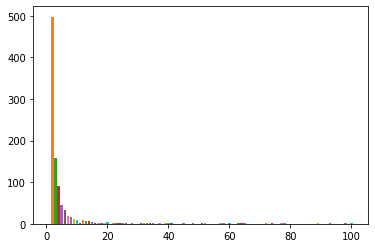

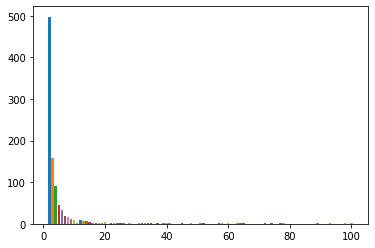

In [325]:
h = np.zeros(100)
for i in temp:
    try:
        h[i]+=1
    except:
        pass
        
ii = 0 
for i in h:
    ii += 1
    plt.bar(ii,i)
plt.show()

ii = 1 
for i in h[1:]:
    ii += 1
    plt.bar(ii,i)
plt.show()

In [326]:
g2.cc = cc

*********************************/////////////////==================================================///////////////////********************************

In [327]:
etrain = g.create_embedding_based_on_input(train)
# etest = g.create_embedding_based_on_input(test)

now we have:

* train: edges
* test: edges
* etrain: matrix

# function for cf and etc.

In [328]:
def edge_convertor(edges):
    temp = []
    for i in range(len(edges[0])):
        temp.append([edges[0][i],edges[1][i]])
    return temp

In [329]:
def negative_sampler(n1,edges,nodes):
    
    n2 = random.choice(nodes)
    while [n1,n2] in edges:
           
        n2 = random.choice(nodes)
    return [n1,n2]

In [330]:
def euclidean_distance(x,y):
    return sum((x-y)**2)**0.5/(sum(abs(x))*sum(abs(y)))

In [331]:
def distance_ranker(item,l):
    s = 1
    for i in l:
        if item>i:
            s+=1 
    return s

In [332]:
raw_train,raw_test = train[:],test[:]  

#model 1: simple Cf

In [334]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(train[::10]):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
    dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
    dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

  0%|          | 3/2095 [00:00<01:10, 29.82it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 2095/2095 [01:13<00:00, 28.61it/s]



train:
 1451 1739 2.2329355608591888


  2%|▏         | 211/8869 [00:08<04:52, 29.65it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 8869/8869 [05:13<00:00, 28.30it/s]


test:
 5708 7157 2.3197654752508736


next phases
* test light_GCN
* test light_GCN with leakage
* test GCN
* test GCN with leakage

# *light_GCN*

In [335]:
etrain.shape

(10000, 10000)

In [336]:
class LGCN:
    def __init__(self):
        pass

    @staticmethod
    def do(inmatrix,VE):
        outmatrix = np.zeros((inmatrix.shape))
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix[j]
            outmatrix[i]/=siz
        return outmatrix

In [337]:

etrain2 = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain2 = LGCN.do(etrain2,g.VnV)

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


In [338]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0

for sample in tqdm(train[::10]):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

 10%|▉         | 201/2095 [00:07<01:04, 29.30it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 2095/2095 [01:13<00:00, 28.60it/s]



train:
 2095 2095 1.0


  5%|▍         | 408/8869 [00:14<04:46, 29.49it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 8869/8869 [05:13<00:00, 28.33it/s]


test:
 8863 8869 1.0006765136994025


# light_GCN with leakage

In [339]:
class LGCNwL:
    def __init__(self):
        pass
    @staticmethod
    def new_neg_vic(inmatrix,VE,leakageratio,lambdaa,cc):
        for c1 in cc:
             if leakageratio>random.random():
                c2 = random.choice(cc)
                while c2 != c1:
                    c2 = random.choice(cc)
                    
                v1 = random.choice(c1)
                v2 = random.choice(c2)
                temp = inmatrix[v1][:]
                inmatrix[v1] -= lambdaa*inmatrix[v2]
                inmatrix[v2] -= lambdaa*temp
        
        return inmatrix

    @staticmethod
    def do(inmatrix,VE,cc,leakageratio=0.3,lambdaa=0.1):
        outmatrix = np.zeros((inmatrix.shape))
        inmatrix2 = LGCNwL.new_neg_vic(np.copy(inmatrix),VE,leakageratio,lambdaa,cc)
      
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix2[j]
            outmatrix[i]/=siz
        return outmatrix

In [340]:

etrain2 = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain2 = LGCNwL.do(etrain2,g2.VnV,g2.cc,leakageratio=0.1,lambdaa=0.1)

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


In [ ]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0

for sample in tqdm(train[::10]):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

 13%|█▎        | 273/2095 [00:09<01:01, 29.52it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 2095/2095 [01:11<00:00, 29.27it/s]



train:
 2080 2087 1.03054892601432


 28%|██▊       | 2499/8869 [01:25<03:37, 29.28it/s]

***50 node 3 component***

*top1,top3,avg:*

**simple cf**
* train:
 106 149 2.52
* test:
 28 36 3.46

**LGCN 3 layer**
* train: 
 154 181 1.30
* test: 
 50 57 1.18

**LGCN 10 layer**
* train: 
133 172 1.53
* test:
 47 57 1.31

**LGCN 100 layer**
* train:
 132 174 1.52
* test:
 43 55 1.44

**LGCNwL 3 layer leakageratio=1 lambdaa=0.1**
* train:
 88 151 2.29
* test:
 25 46 2.51

In [ ]:
len(g.cc)

LGCNwL type 2

In [ ]:
class LGCNwL2:
    def __init__(self):
        pass
    @staticmethod
    def new_neg_vic(inmatrix,VE,leakageratio,lambdaa,cc):
        for c1 in range(len(cc)):
             if leakageratio>random.random():
                c2 = random.randint(len(cc))
                while c2 != c1:
                    c2 = random.randint(len(cc))
                    
                v1 = cc(c1)
                v2 = cc(c2)
                vv1 = random.choice(v1)
                vv2 = random.choice(v2)
                temp = inmatrix[vv1]
                temp2 = lambdaa*inmatrix[vv2]
                for v in v1:
                    inmatrix[v] -= lambdaa*temp2
                for v in v2:
                    inmatrix[v] -= lambdaa*temp
        
        return inmatrix

    @staticmethod
    def do(inmatrix,VE,cc,leakageratio=0.3,lambdaa=0.1):
        outmatrix = np.zeros((inmatrix.shape))
        inmatrix2 = LGCNwL.new_neg_vic(np.copy(inmatrix),VE,leakageratio,lambdaa,cc)
      
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix2[j]
            outmatrix[i]/=siz
        return outmatrix

In [ ]:

etrain2 = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain2 = LGCNwL2.do(etrain2,g2.VnV,g2.cc,leakageratio=0.3,lambdaa=0.1)

In [ ]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0

for sample in tqdm(train[::10]):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

In [ ]:
len(g.V),len(g.edge_index()[0]),len(g.edge_index()[0])/len(g.V)

In [ ]:
len(train),len(train[::10]),len(test)